In [1]:
# Initialize the libs and download the dataset
!pip3 install mne -q
!pip3 install awscli
!aws s3 sync --no-sign-request s3://openneuro.org/ds003626 ds003626/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-auth-oauthlib 1.0.0 requires google-auth>=2.15.0, but you have google-auth 1.4.2 which is incompatible.
botocore 1.29.137 requires urllib3<1.27,>=1.25.4, but you have urllib3 1.24.3 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
  Using cached urllib3-1.26.15-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.21.0 requires urllib3<1.25,>=1.21.1, but you have urllib3 1.26.15 which is incompatible.
google-auth-oauthlib 1.0.0 requires google-auth>=2.15.0, but you have google-auth 1.4.2 which is incompatible.


^C


In [17]:
import mne
import warnings
import numpy as np
import pandas as pd

np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning )
warnings.filterwarnings(action = "ignore", category = FutureWarning )

In [39]:
# The root dir
root_dir = "C:/Users/hazem/Downloads/ds003626"

# Sampling rate
fs = 256

# Select the useful par of each trial. Time in seconds
t_start = 1.5
t_end = 3.5

In [40]:
from au.pre_process import get_subjects_data_and_label

condition = "Inner"

data, labels = get_subjects_data_and_label(root_dir, condition, t_start = t_start, t_end = t_end, fs = fs)

In [41]:
print("Number of subjects", len(data))
print("Data shape: [trials x channels x samples]")
print("Shape", data[0].shape) # Trials, channels, samples

print("Labels")
print(len(labels)) # Time stamp, class , condition, session

Number of subjects 10
Data shape: [trials x channels x samples]
Shape (200, 128, 512)
Labels
10


In [42]:
import numpy as np
data_array=np.vstack(data)
label_array=np.hstack(labels)
print(data_array.shape, label_array.shape)

(2236, 128, 512) (2236,)


In [43]:
from scipy.signal import welch
import numpy as np
def psd_welch(data, fs):
    """Compute the power spectral density (PSD) using the Welch method.

    Parameters
    ----------
    data : array-like, shape (n_samples, n_channels, n_times)
        The data.
    fs : float
        The sampling frequency.

    Returns
    -------
    psds : array-like, shape (n_samples, n_channels, n_freqs)
        The PSDs.
    freqs : array-like, shape (n_freqs,)
        The frequencies.
    """
    n_freqs= 129
    n_samples, n_channels, n_times = data.shape
    psds = np.zeros((n_samples, n_channels, n_freqs))
    freqs = np.zeros(n_freqs)

    for i in range(n_samples):
        for j in range(n_channels):
            f, pxx = welch(data[i, j, :], fs=fs)
            psds[i, j, :] = pxx
            freqs = f

    return psds, freqs

psds, freqs=  psd_welch(data_array, fs)


In [44]:
print(psds)
print(freqs)

[[[7.92241868e-13 3.36811658e-12 3.96532221e-12 ... 7.35845800e-20
   2.06678656e-19 1.08964955e-19]
  [8.93977196e-13 3.40396544e-12 4.17536311e-12 ... 9.36555980e-20
   1.32451247e-19 8.30041644e-20]
  [8.62414907e-13 3.41250530e-12 4.03688638e-12 ... 7.09338615e-20
   1.86357464e-19 6.31156342e-20]
  ...
  [1.12373779e-12 8.80636637e-12 3.53716561e-12 ... 2.14253806e-19
   1.78334787e-19 1.25061075e-19]
  [1.99892006e-12 5.89833796e-12 4.15031060e-12 ... 3.41877969e-19
   9.85063007e-20 4.28402949e-20]
  [2.03728653e-12 5.89414690e-12 4.06353554e-12 ... 4.41899612e-19
   7.49202704e-20 3.10007962e-20]]

 [[3.03770937e-13 5.65897674e-12 1.30958678e-11 ... 7.66661677e-20
   8.29739115e-20 1.84638500e-20]
  [3.18572578e-13 5.11817729e-12 1.22439817e-11 ... 7.21202702e-20
   9.21597132e-20 7.07601111e-21]
  [3.53688022e-13 5.58988283e-12 1.30834902e-11 ... 9.77490489e-20
   1.28568318e-19 5.94652498e-20]
  ...
  [2.67482526e-12 1.72374234e-11 9.08540286e-12 ... 6.64591509e-20
   7.26427

In [45]:
import numpy as np

# Reshape the PSDs array into a 2D array
n_samples, n_channels, n_freqs = psds.shape
psds_2d = np.reshape(psds, (n_samples, n_channels * n_freqs))

In [46]:
from sklearn.decomposition import PCA

# Create a PCA object
pca = PCA(n_components=10, random_state=42)

# Fit the PCA model to the data
pca.fit(psds_2d)

# Transform the data using the PCA model
psds_pca = pca.transform(psds_2d)

In [17]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics, model_selection
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# This section contains the function to support the model evaluation


def run_cross_validation(classifier, x_tr, y_tr):
    k_fold = model_selection.KFold(n_splits=4)
    results = model_selection.cross_val_score(classifier, x_tr, y_tr, cv=k_fold, scoring='accuracy')
    print('{:<50} {:.4f}'.format("Cross validation average accuracy with 4-fold:", (results.mean())))

def run_accuracy(y_tst, y_p):
    print('{:<50} {:.4f}'.format("Accuracy", (metrics.accuracy_score(y_tst, y_p))))

def plot_confusion_matrix(y_tst, y_pred, y_labels):
    lbs = y_labels.unique()
    confusion_matrix = metrics.confusion_matrix(y_tst, y_pred)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel("Predicted label", fontsize =15)
    ax.set_ylabel("True Label", fontsize=15)
    ax.set_yticklabels(list(lbs), rotation = 0)
    plt.show()

# Extract importance
def print_importance(classifier, x_tr):
    importance = pd.DataFrame({'feature': x_tr.columns, 'importance' : np.round(classifier.feature_importances_, 3)})
    importance.sort_values('importance', ascending=False, inplace = True)
    print(importance)

In [12]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def run_random_forest():
    print("Random Forest")
    # Split dataset into training set and test set
    x_train, x_test, y_train, y_test = train_test_split(psds_pca, label_array, test_size=0.30) # 70% test and 30% training
    clf = RandomForestClassifier(n_estimators=100)

    # Train the model
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    run_accuracy(y_test, y_pred)
    run_cross_validation(clf, x_train, y_train)
    print(classification_report(y_test, y_pred))
    # evaluate_model(clf, x_train, x_test, y_train, y_test)

run_random_forest()

Random Forest
Accuracy                                           0.2280
Cross validation average accuracy with 10-fold:    0.2492
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       185
           1       0.00      0.00      0.00       174
           2       0.23      1.00      0.37       153
           3       0.00      0.00      0.00       159

    accuracy                           0.23       671
   macro avg       0.06      0.25      0.09       671
weighted avg       0.05      0.23      0.08       671



C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [12]:
# Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

def run_neural_network():
    print("Neural Network")
    # Split dataset into training set and test set
    x_train, x_test, y_train, y_test = train_test_split(psds_pca, label_array, test_size=0.20) # 80% test and 20% training
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

    # Train the model
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    run_accuracy(y_test, y_pred)
    run_cross_validation(clf, x_train, y_train)
    print(classification_report(y_test, y_pred))
    #plot_confusion_matrix(y_test, y_pred, label_array)

run_neural_network()

Neural Network
Accuracy                                           0.2277
Cross validation average accuracy with 10-fold:    0.2388
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       137
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00       106
           3       0.23      1.00      0.37       102

    accuracy                           0.23       448
   macro avg       0.06      0.25      0.09       448
weighted avg       0.05      0.23      0.08       448



C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [13]:
# Multiclass Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

def run_random_forest_multi_class():
    print("Random Forest")
    # Split dataset into training set and test set
    x_train, x_test, y_train, y_test = train_test_split(psds_pca, label_array, test_size=0.20) # 80% test and 20% training
    rf = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')
    clf = OneVsRestClassifier(rf)

    # Train the model
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    run_accuracy(y_test, y_pred)
    run_cross_validation(clf, x_train, y_train)
    print(classification_report(y_test, y_pred))
    #print_importance(clf, x_train)
    #plot_confusion_matrix(y_test, y_pred)

run_random_forest_multi_class()

Random Forest


C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

Accuracy                                           0.2277


C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

Cross validation average accuracy with 10-fold:    0.2388
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       104
           2       0.23      1.00      0.37       102
           3       0.00      0.00      0.00       126

    accuracy                           0.23       448
   macro avg       0.06      0.25      0.09       448
weighted avg       0.05      0.23      0.08       448



C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [14]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

def run_random_forest(X, y):
    print("Random Forest")
    # Split dataset into training set and test set
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20) # 80% test and 20% training
    clf = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

    # Train the model
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    run_accuracy(y_test, y_pred)
    run_cross_validation(clf, x_train, y_train)
    print(classification_report(y_test, y_pred))
    #print_importance(clf, x_train)
    #plot_confusion_matrix(y_test, y_pred)

run_random_forest(psds_pca, label_array)

Random Forest


C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy                                           0.2299


C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or r

Cross validation average accuracy with 10-fold:    0.2237
              precision    recall  f1-score   support

           0       0.23      1.00      0.37       103
           1       0.00      0.00      0.00       116
           2       0.00      0.00      0.00       105
           3       0.00      0.00      0.00       124

    accuracy                           0.23       448
   macro avg       0.06      0.25      0.09       448
weighted avg       0.05      0.23      0.09       448



C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

def run_linear_svc_multi_class():
    print("Linear SVC")
    # Split dataset into training set and test set
    x_train, x_test, y_train, y_test = train_test_split(psds_pca, label_array, test_size=0.30) # 70% test and 30% training
    rf = LinearSVC(random_state=0, max_iter=10000)
    clf = OneVsRestClassifier(rf)

    # Train the model
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    run_accuracy(y_test, y_pred)
    run_cross_validation(clf, x_train, y_train)
    print(classification_report(y_test, y_pred))

run_linear_svc_multi_class()

Linear SVC
Accuracy                                           0.2325
Cross validation average accuracy with 10-fold:    0.2377
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       183
           1       0.00      0.00      0.00       169
           2       0.23      1.00      0.38       156
           3       0.00      0.00      0.00       163

    accuracy                           0.23       671
   macro avg       0.06      0.25      0.09       671
weighted avg       0.05      0.23      0.09       671



C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hazem\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [18]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

def run_svm_multi_class():
    print("SVM")
    # Split dataset into training set and test set
    x_train, x_test, y_train, y_test = train_test_split(psds_pca, label_array, test_size=0.30) # 70% test and 30% training
    svm = SVC(random_state=0, max_iter=10000)
    clf = OneVsRestClassifier(svm)

    # Train the model
    clf.fit(x_train, y_train)

    # Evaluate
    y_pred = clf.predict(x_test)

    run_accuracy(y_test, y_pred)
    run_cross_validation(clf, x_train, y_train)
    print(classification_report(y_test, y_pred))

run_svm_multi_class()

SVM
Accuracy                                           0.2235
Cross validation average accuracy with 4-fold:     0.2601
              precision    recall  f1-score   support

           0       0.25      0.04      0.06       163
           1       0.20      0.33      0.25       151
           2       0.22      0.11      0.15       175
           3       0.24      0.41      0.30       182

    accuracy                           0.22       671
   macro avg       0.23      0.22      0.19       671
weighted avg       0.23      0.22      0.19       671



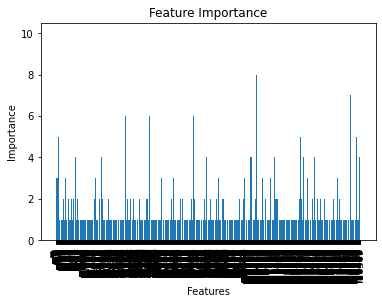

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


['f5551', 'f10420', 'f10979', 'f13536', 'f3348']
Accuracy: 0.22503725782414308


In [33]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(psds_2d, label_array, test_size=0.30) # 70% test and 30% training

# Step 1: Prepare the data as numpy arrays
X_train = np.array(X_train)  # Replace ... with your X_train data
X_test = np.array(X_test)   # Replace ... with your X_test data
y_train = np.array(y_train)  # Replace ... with your y_train data
y_test = np.array(y_test)   # Replace ... with your y_test data

# Step 2: Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# Step 3: Set hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'num_class': len(set(y_train)),  # Number of classes
    'objective': 'multi:softmax',    # Objective function for multi-class classification
    'eval_metric': 'mlogloss'        # Evaluation metric for multi-class classification
}

num_boost_round = 100

# Step 4: Train the model
model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# Step 5: Retrieve feature importance
feature_importance = model.get_score()

# Step 6: Visualize feature importance
features, importance = zip(*feature_importance.items())

plt.bar(features, importance)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# Step 7: Select features
top_n = 5
selected_features = sorted(feature_importance, key=feature_importance.get, reverse=True)[:top_n]

# Step 8: Create new datasets with selected features
X_train_selected = X_train[:, np.where((list(X_train), selected_features))[0]]
X_test_selected = X_test[:, np.where((list(X_test), selected_features))[0]]

# print(X_train_selected)
print(selected_features)
# Step 9: Train a new model with selected features
dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train)
model_selected = xgb.train(params, dtrain_selected, num_boost_round=num_boost_round)

# Step 10: Make predictions on the test set
dtest_selected = xgb.DMatrix(X_test_selected)
predictions = model_selected.predict(dtest_selected)

# Step 11: Evaluate the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

In [47]:
from scipy.signal import welch
import numpy as np
def psd_welch_forXG(data, fs):
    """Compute the power spectral density (PSD) using the Welch method.
    Parameters
    ----------
    data : array-like, shape (n_samples, n_channels, n_times)
        The data.
    fs : float
        The sampling frequency.
    Returns
    -------
    psds : array-like, shape (n_samples, n_channels, n_freqs)
        The PSDs.
    freqs : array-like, shape (n_freqs,)
        The frequencies.
    """
    n_freqs= 129
    n_samples, n_channels, n_times = data.shape
    psds = np.zeros((n_samples, n_channels, n_freqs))
    freqs = np.zeros(n_freqs)
    FREQ_BANDS = {"alpha": [8.0, 13.0],
                  "beta": [13.0, 30.0],
                  "gamma": [30.0, 100.0],
                  }
    for i in range(n_samples):
        for j in range(n_channels):
            f, pxx = welch(data[i, j, :], fs=fs)
            psds[i, j, :] = pxx
            freqs = f
    psds /= np.sum(psds, axis=-1, keepdims=True)    # Normalize the PSDs

    X = []#For each frequency band, compute the mean PSD in that band
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)# Compute the mean PSD in each frequency band.
        X.append(psds_band)

    return (np.concatenate(X, axis=1)) , (freqs)

psds, freqs=  psd_welch_forXG(data_array, fs)


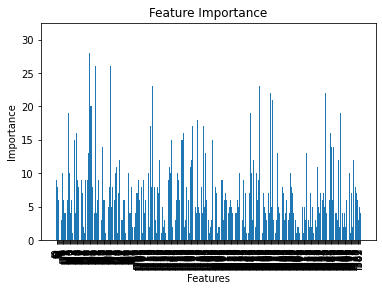

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


['f300', 'f40', 'f281', 'f50', 'f68']
Accuracy: 0.2697466467958271


In [38]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(psds, label_array, test_size=0.30) # 70% test and 30% training

# Step 1: Prepare the data as numpy arrays
X_train = np.array(X_train)  # Replace ... with your X_train data
X_test = np.array(X_test)   # Replace ... with your X_test data
y_train = np.array(y_train)  # Replace ... with your y_train data
y_test = np.array(y_test)   # Replace ... with your y_test data

# Step 2: Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# Step 3: Set hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'num_class': len(set(y_train)),  # Number of classes
    'objective': 'multi:softmax',    # Objective function for multi-class classification
    'eval_metric': 'mlogloss'        # Evaluation metric for multi-class classification
}

num_boost_round = 100

# Step 4: Train the model
model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# Step 5: Retrieve feature importance
feature_importance = model.get_score()

# Step 6: Visualize feature importance
features, importance = zip(*feature_importance.items())

plt.bar(features, importance)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# Step 7: Select features
top_n = 5
selected_features = sorted(feature_importance, key=feature_importance.get, reverse=True)[:top_n]

# Step 8: Create new datasets with selected features
X_train_selected = X_train[:, np.where((list(X_train), selected_features))[0]]
X_test_selected = X_test[:, np.where((list(X_test), selected_features))[0]]

# print(X_train_selected)
print(selected_features)
# Step 9: Train a new model with selected features
dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train)
model_selected = xgb.train(params, dtrain_selected, num_boost_round=num_boost_round)

# Step 10: Make predictions on the test set
dtest_selected = xgb.DMatrix(X_test_selected)
predictions = model_selected.predict(dtest_selected)

# Step 11: Evaluate the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)